代码参考：https://cohere.com/llmu/what-is-similarity-between-sentences 

改动：
* 替换Cohere API，调用[SiliconFlow](https://siliconflow.cn/zh-cn/) API生成句子向量
* 增加自己实现余弦相似度的部分
* 用自己实现的余弦相似度替换sklearn中的余弦相似度

In [1]:
import math
import requests
import json
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity as sk_cosine_similarity  # 调用sklearn计算余弦相似度

# 调用模型生成句子向量

In [2]:
texts = ["I like to be in my house", 
         "I enjoy staying home", 
         "the isotope 238u decays to 206pb"]
model = "BAAI/bge-large-en-v1.5"  # 查看模型信息 https://cloud.siliconflow.cn/models
api_key = ""  # 填入API密钥

In [3]:
url = "https://api.siliconflow.cn/v1/embeddings"

payload = {
    "model": model,  # 配置LLM embedding model
    "input": texts,
    "encoding_format": "float"
}
headers = {
    "Authorization": api_key,  # 添加siliconflow API 密钥，https://cloud.siliconflow.cn/account/ak
    "Content-Type": "application/json"
}

response = requests.request("POST", url, json=payload, headers=headers)

In [4]:
type(response)

requests.models.Response

In [5]:
type(response.text)

str

In [6]:
response_embeds = json.loads(response.text)["data"]

In [7]:
embeddings = [response_embeds[i]["embedding"] for i in range(len(texts))]

In [8]:
[sentence1, sentence2, sentence3] = embeddings

In [9]:
print("Embedding for sentence 1", np.array(sentence1))
print("Embedding for sentence 2", np.array(sentence2))
print("Embedding for sentence 3", np.array(sentence3))

Embedding for sentence 1 [-0.02156916  0.00039248 -0.02974168 ... -0.05719334 -0.03269009
 -0.01343242]
Embedding for sentence 2 [-0.03370305  0.01532354 -0.01720078 ... -0.0558225  -0.01431943
 -0.02991946]
Embedding for sentence 3 [-0.00024108  0.01346142 -0.00220542 ... -0.03132343 -0.0314601
 -0.0127371 ]


# 编程实现现计算余弦相似度的函数

In [ ]:
def cosine_similarity(emb1, emb2):
    """
    计算两个向量的余弦相似度
    emb1和emb2类型是list，二者维度相同
    比如 emb1=[0.1, 0.2, 0.1]
    """
    # 实现余弦相似度
    emb1, emb2 = np.array(emb1), np.array(emb2)
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

In [11]:
epsilon = 1e-9

def is_close(a, b, epsilon):
    """判断两个浮点数是否相等"""
    return math.isclose(a, b, rel_tol=epsilon)

In [12]:
def test_answer(A, B, epsilon):
    """测试数值A和B是否相同(误差范围内)"""
    if is_close(A, B, epsilon):
        print("Pass")
    else:
        print("Fail")

In [13]:
test_answer(cosine_similarity(sentence1, sentence2), sk_cosine_similarity([sentence1], [sentence2])[0][0], epsilon)
test_answer(cosine_similarity(sentence1, sentence3), sk_cosine_similarity([sentence1], [sentence3])[0][0], epsilon)
test_answer(cosine_similarity(sentence2, sentence3), sk_cosine_similarity([sentence2], [sentence3])[0][0], epsilon)

Pass
Pass
Pass


恭喜🎉 后面就用我们自己实现的余弦相似度了

# 可视化

In [15]:
# 计算两个不同句子向量的余弦相似度
print("Cosine similarity between sentences 1 and 2:", cosine_similarity(sentence1, sentence2))  
print("Cosine similarity between sentences 1 and 3:", cosine_similarity(sentence1, sentence3))  
print("Cosine similarity between sentences 2 and 3:", cosine_similarity(sentence2, sentence3))


Cosine similarity between sentences 1 and 2: 0.8399703091419068
Cosine similarity between sentences 1 and 3: 0.4265597337598573
Cosine similarity between sentences 2 and 3: 0.42858240671154135


In [16]:
# 每个句子向量和自己的余弦相似度
print("Cosine similarity between sentences 1 and 1:", cosine_similarity(sentence1, sentence1))
print("Cosine similarity between sentences 2 and 2:", cosine_similarity(sentence2, sentence2))
print("Cosine similarity between sentences 3 and 3:", cosine_similarity(sentence3, sentence3))

Cosine similarity between sentences 1 and 1: 1.0
Cosine similarity between sentences 2 and 2: 0.9999999999999999
Cosine similarity between sentences 3 and 3: 1.0000000000000002


[Text(0.5, 0, 'I like to be in my house'),
 Text(1.5, 0, 'I enjoy staying home'),
 Text(2.5, 0, 'the isotope 238u decays to 206pb')]

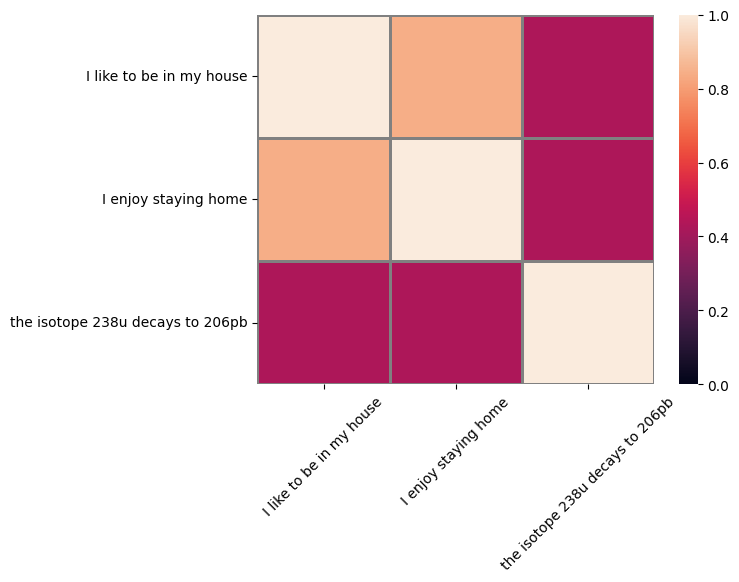

In [17]:
# Get pairwise dot product similarities
cosine_similarities = [[cosine_similarity(embeddings[i], embeddings[j]) for i in range(len(embeddings))] for j in range(len(embeddings))]

# Plot in 3x3 grid
ax = sns.heatmap(cosine_similarities, vmin=0, vmax=1,
                 linewidths=1, linecolor='grey',
                 xticklabels=texts,
                 yticklabels=texts,
)
ax.set_xticklabels(labels=texts, rotation=45)